# YOLIC - You Only Look at Interested Cells

## 1. Common YOLIC code

#### 1.1 Imports and constants

In [56]:
from typing import Any
from os import listdir
from pathlib import Path 

from PIL import Image

import torch
import torch.nn as nn

import cv2

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

from torch.utils.data import Dataset, DataLoader

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision import transforms

from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryRecall, BinaryPrecision

from alive_progress import alive_bar

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [57]:
NUMBER_OF_COIS = 104
NUMBER_OF_CLASSES = 11

YOLIC_NET_INPUT_WIDTH = 224
YOLIC_NET_INPUT_HEIGHT = 224

TRAIN_IMAGE_DIR = Path("../Outdoor/images/train/Outdoor/")
VAL_IMAGE_DIR = Path("../Outdoor/images/val/Outdoor/")
TEST_IMAGE_DIR = Path("../Outdoor/images/test/Outdoor/")

LABEL_DIR = Path("../Outdoor/labels/")

CSV_FILE = Path("training_data.csv")

YOLIC_MODEL_PATH = Path("yolic_model.pt")

#### 1.2 Dataset class

In [58]:
class YolicDataset(Dataset):
    """Yolic Dataset class used to load images and label"""

    def __init__(
        self,
        image_dir: Path,
        label_dir: Path,
        transform=None,
    ):
        """Initialize YolicDataset class"""
        self._image_dir = image_dir
        self._label_dir = label_dir
        self._image_names = listdir(image_dir)
        self._transform = transform

    def __len__(self) -> int:
        """Return the length of the dataset"""
        return len(self._image_names)

    def __getitem__(self, index) -> tuple[Any, torch.Tensor, str]:
        """Return image, label and image name"""

        image_name = Path(self._image_names[index])

        image_path = self._image_dir / image_name
        label_path = self._label_dir / image_name.with_suffix(".txt")

        label = torch.from_numpy(np.loadtxt(fname=label_path, dtype=np.float32))

        image = Image.open(image_path).convert("RGB")

        if self._transform is not None:
            image = self._transform(image)
        # add random augmentation here
        filename = image_name.stem
        return image, label, filename

#### 1.3 Model function

In [59]:
def yolic_net(weights=None) -> nn.Module:
    """Returns a Yolic model"""

    model = mobilenet_v2(weights=weights)
    model.classifier = nn.Sequential(  # Swap out the classifier
        nn.Dropout(p=0.2),
        nn.Linear(
            in_features=model.last_channel,
            out_features=(NUMBER_OF_COIS * (NUMBER_OF_CLASSES + 1)),
        ),
    )
    return model

In [60]:
from torchsummary import summary
model = yolic_net()
summary(model.cuda(), (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## 2. Train YOLIC

#### 2.1 Accuracy function

In [61]:
# This function has been copied from the original yolic repository,
# not fully understood yet
def yolic_accuracy(
    preds: torch.Tensor,
    targets: torch.Tensor,
) -> float:
    """Calculate accuracy of the model"""
    accuracy = 0.0
    for i, pred in enumerate(preds):
        target = targets[i]
        target = torch.Tensor.cpu(target)
        pred = torch.Tensor.cpu(pred)

        pred = torch.round(pred).detach().numpy().astype(np.int64)
        target = target.detach().numpy()
        pred = np.reshape(pred, (NUMBER_OF_COIS * (NUMBER_OF_CLASSES + 1), 1)).flatten()
        target = np.reshape(
            target, (NUMBER_OF_COIS * (NUMBER_OF_CLASSES + 1), 1)
        ).flatten()
        num = 0
        single_accuracy = 0.0
        for cell in range(
            0, (NUMBER_OF_COIS * (NUMBER_OF_CLASSES + 1)), NUMBER_OF_CLASSES + 1
        ):
            if (
                target[cell : cell + NUMBER_OF_CLASSES + 1]
                == pred[cell : cell + NUMBER_OF_CLASSES + 1]
            ).all():
                num = num + 1

            single_accuracy = num / NUMBER_OF_COIS
        accuracy += single_accuracy
    accuracy = accuracy / len(preds)
    return accuracy

#### 2.2 Train and validation step

In [62]:
def train_step(
    model: nn.Module,
    loss_fn: Any,
    accuracy_fn: Any,
    f1_score_fn: Any,
    precision_fn: Any,
    recall_fn: Any,
    optimizer: optim.Optimizer,
    device: torch.device,
    data_loader: DataLoader,
) -> tuple[float, float]:
    """Perform a single training step"""

    train_loss = 0.0
    all_outputs = []
    all_labels = []
    model.train()
    with alive_bar(len(data_loader)) as bar:
        for images, labels, _ in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward pass
            output = model(images)
            loss = loss_fn(output, labels)
            train_loss += loss.item()

            output = torch.sigmoid(output)

            all_outputs.append(output.detach().cpu())
            all_labels.append(labels.detach().cpu())

            # backward pass
            loss.backward()
            optimizer.step()

            # update the progress bar
            bar()

    train_loss = train_loss / len(data_loader)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    train_accuracy = accuracy_fn(all_outputs, all_labels)
    train_f1_score = f1_score_fn(all_outputs, all_labels)
    train_precision = precision_fn(all_outputs, all_labels)
    train_recall = recall_fn(all_outputs, all_labels)

    return train_loss, train_accuracy, train_f1_score, train_precision, train_recall

In [63]:
def validation_step(
    model: nn.Module,
    loss_fn: Any,
    accuracy_fn: Any,
    f1_score_fn: Any,
    precision_fn: Any,
    recall_fn: Any,
    device: torch.device,
    data_loader: DataLoader,
) -> tuple[float, float]:
    """Perform validation of a model"""

    validation_loss = 0.0
    all_outputs = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)

            loss = loss_fn(output, labels)
            validation_loss += loss.item()

            output = torch.sigmoid(output)

            all_outputs.append(output.detach().cpu())
            all_labels.append(labels.detach().cpu())

    validation_loss = validation_loss / len(data_loader)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    validation_accuracy = accuracy_fn(all_outputs, all_labels)
    validation_f1_score = f1_score_fn(all_outputs, all_labels)
    validation_precision = precision_fn(all_outputs, all_labels)
    validation_recall = recall_fn(all_outputs, all_labels)

    return (
        validation_loss,
        validation_accuracy,
        validation_f1_score,
        validation_precision,
        validation_recall,
    )

#### 2.3 Hyperparameters

In [64]:
EPOCHS = 40
BATCH_SIZE = 45
LEARNING_RATE = 0.001

THRESHOLD = 0.5

#### 2.4 YOLIC train function

In [65]:
def yolic_train():
    """Main function"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")

    # Declare model, loss function, optimizer and scheduler
    model = yolic_net(weights=MobileNet_V2_Weights.DEFAULT)
    model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = MultiStepLR(optimizer, milestones=[20, 25], gamma=0.1)

    # Declare transforms
    train_transform = transforms.Compose(
        (
            [
                transforms.Resize((YOLIC_NET_INPUT_HEIGHT, YOLIC_NET_INPUT_WIDTH)),
                transforms.ColorJitter(
                    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
                ),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
    )
    validation_transform = transforms.Compose(
        (
            [
                transforms.Resize((YOLIC_NET_INPUT_HEIGHT, YOLIC_NET_INPUT_WIDTH)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
    )

    # Create datasets
    train_dataset = YolicDataset(TRAIN_IMAGE_DIR, LABEL_DIR, train_transform)
    validation_dataset = YolicDataset(VAL_IMAGE_DIR, LABEL_DIR, validation_transform)
    print(f"Train data: {len(train_dataset)}")
    print(f"Validation data: {len(validation_dataset)}")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
    )
    validation_loader = DataLoader(
        validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
    )

    # Train model
    train_loss = []
    train_accuracy = []
    train_f1_score = []
    train_precision = []
    train_recall = []

    validation_loss = []
    validation_accuracy = []
    validation_f1_score = []
    validation_precision = []
    validation_recall = []

    previous_validation_accuracy = 0.0
    for epoch in range(EPOCHS):
        print(f"\nEpoch: {epoch+1} / {EPOCHS}")
        (
            epoch_train_loss,
            epoch_train_accuracy,
            epoch_train_f1_score,
            epoch_train_precision,
            epoch_train_recall,
        ) = train_step(
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=BinaryAccuracy(THRESHOLD),
            f1_score_fn=BinaryF1Score(THRESHOLD),
            precision_fn=BinaryPrecision(THRESHOLD),
            recall_fn=BinaryRecall(THRESHOLD),
            optimizer=optimizer,
            device=device,
            data_loader=train_loader,
        )

        (
            epoch_validation_loss,
            epoch_validation_accuracy,
            epoch_validation_f1_score,
            epoch_validation_precision,
            epoch_validation_recall,
        ) = validation_step(
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=BinaryAccuracy(THRESHOLD),
            f1_score_fn=BinaryF1Score(THRESHOLD),
            precision_fn=BinaryPrecision(THRESHOLD),
            recall_fn=BinaryRecall(THRESHOLD),
            device=device,
            data_loader=validation_loader,
        )
        scheduler.step()

        print(
            f"Train loss: {epoch_train_loss},",
            f"Train accuracy: {epoch_train_accuracy}",
            f"Train f1 score: {epoch_train_f1_score}",
            f"Train precision: {epoch_train_precision}",
            f"Train recall: {epoch_train_recall}",
        )
        print(
            f"Validation loss: {epoch_validation_loss},",
            f"Validation accuracy: {epoch_validation_accuracy}",
            f"Validation f1 score: {epoch_validation_f1_score}",
            f"Validation precision: {epoch_validation_precision}",
            f"Validation recall: {epoch_validation_recall}",
        )

        # TODO: Change metric to precision, recall or f1 score
        if epoch_validation_accuracy > previous_validation_accuracy:
            torch.save(model.state_dict(), YOLIC_MODEL_PATH)
            previous_validation_accuracy = epoch_validation_accuracy
            print(f"Saved new weights as {YOLIC_MODEL_PATH}")

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        train_f1_score.append(epoch_train_f1_score)
        train_precision.append(epoch_train_precision)
        train_recall.append(epoch_train_recall)


        validation_loss.append(epoch_validation_loss)
        validation_accuracy.append(epoch_validation_accuracy)
        validation_f1_score.append(epoch_validation_f1_score)
        validation_precision.append(epoch_validation_precision)
        validation_recall.append(epoch_validation_recall)

        pd.DataFrame(
            {
                "train_loss": train_loss,
                "validation_loss": validation_loss,
                "train_accuracy": train_accuracy,
                "validation_accuracy": validation_accuracy,
                "train_f1_score": train_f1_score,
                "validation_f1_score": validation_f1_score,
                "train_precision": train_precision,
                "validation_precision": validation_precision,
            }
        ).to_csv(CSV_FILE, index=False)
        print(f"Added new metrics to {CSV_FILE}")

#### 2.5 Start YOLIC training

In [66]:
yolic_train()

Using cuda
Train data: 16304
Validation data: 2038

Epoch: 1 / 40
|████████████████████████████████████████| 363/363 [100%] in 1:10.2 (5.17/s) 
Train loss: 0.06622139282380911, Train accuracy: 0.9779582619667053 Train f1 score: 0.8665118217468262 Train precision: 0.8863576650619507 Train recall: 0.8475351929664612
Validation loss: 0.035483163902940956, Validation accuracy: 0.9864171147346497 Validation f1 score: 0.9174778461456299 Validation precision: 0.9409176707267761 Validation recall: 0.8951774835586548
Saved new weights as yolic_model.pt
Added new metrics to training_data.csv

Epoch: 2 / 40
|████████████████████████████████████████| 363/363 [100%] in 1:09.2 (5.25/s) 
Train loss: 0.03316401265889981, Train accuracy: 0.9871136546134949 Train f1 score: 0.9221784472465515 Train precision: 0.9405249953269958 Train recall: 0.9045339226722717
Validation loss: 0.027532293582740036, Validation accuracy: 0.9892078638076782 Validation f1 score: 0.9348903298377991 Validation precision: 0.951

#### 2.6 Plot training data

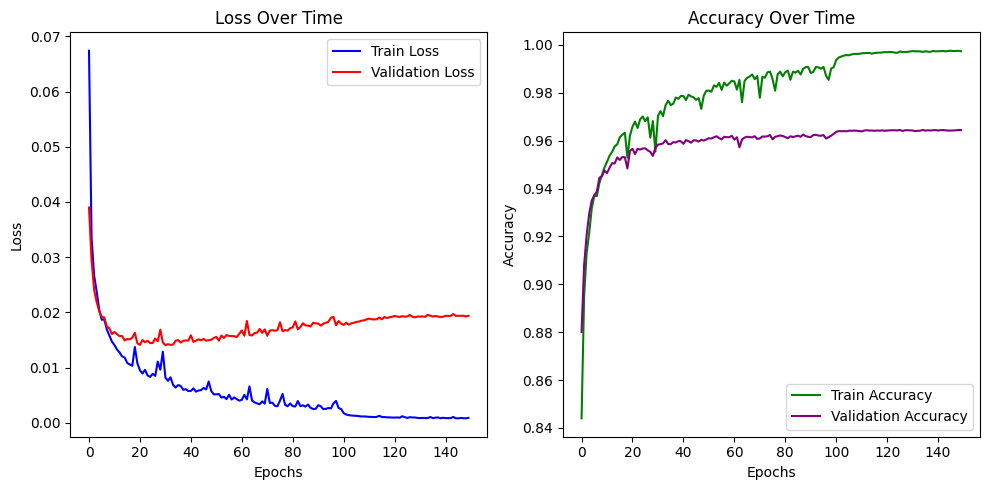

In [26]:
data = pd.read_csv(CSV_FILE)

# Extract the columns
train_loss = data['train_loss']
validation_loss = data['validation_loss']
train_accuracy = data['train_accuracy']
validation_accuracy = data['validation_accuracy']

# Create the first plot for loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='red')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Create the second plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.plot(validation_accuracy, label='Validation Accuracy', color='purple')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

## 3. Test YOLIC

#### 3.1 Generated images directory

In [27]:
GENERATED_IMAGE_DIR = Path("generated_images")

#### 3.2 Cells and classes

In [29]:
points_list = [
    (288, 166),
    (322, 166),
    (356, 166),
    (390, 166),
    (424, 166),
    (458, 166),
    (492, 166),
    (526, 166),
    (220, 200),
    (254, 200),
    (288, 200),
    (322, 200),
    (356, 200),
    (390, 200),
    (424, 200),
    (458, 200),
    (492, 200),
    (526, 200),
    (560, 200),
    (594, 200),
    (220, 234),
    (254, 234),
    (288, 234),
    (322, 234),
    (356, 234),
    (390, 234),
    (424, 234),
    (458, 234),
    (492, 234),
    (526, 234),
    (560, 234),
    (594, 234),
    (628, 234),
    (254, 268),
    (288, 268),
    (322, 268),
    (356, 268),
    (390, 268),
    (424, 268),
    (458, 268),
    (492, 268),
    (526, 268),
    (560, 268),
    (594, 268),
    (628, 268),
    (0, 268),
    (53, 268),
    (106, 268),
    (159, 268),
    (212, 268),
    (265, 268),
    (318, 268),
    (371, 268),
    (424, 268),
    (477, 268),
    (530, 268),
    (583, 268),
    (636, 268),
    (689, 268),
    (742, 268),
    (795, 268),
    (0, 321),
    (53, 321),
    (106, 321),
    (159, 321),
    (212, 321),
    (265, 321),
    (318, 321),
    (371, 321),
    (424, 321),
    (477, 321),
    (530, 321),
    (583, 321),
    (636, 321),
    (689, 321),
    (742, 321),
    (795, 321),
    (848, 321),
    (0, 374),
    (53, 374),
    (106, 374),
    (159, 374),
    (212, 374),
    (265, 374),
    (318, 374),
    (371, 374),
    (424, 374),
    (477, 374),
    (530, 374),
    (583, 374),
    (636, 374),
    (689, 374),
    (742, 374),
    (795, 374),
    (848, 374),
    (0, 427),
    (53, 427),
    (106, 427),
    (159, 427),
    (212, 427),
    (265, 427),
    (318, 427),
    (371, 427),
    (424, 427),
    (477, 427),
    (530, 427),
    (583, 427),
    (636, 427),
    (689, 427),
    (742, 427),
    (795, 427),
    (848, 427),
    (0, 480),
    (53, 480),
    (106, 480),
    (159, 480),
    (212, 480),
    (265, 480),
    (318, 480),
    (371, 480),
    (424, 480),
    (477, 480),
    (530, 480),
    (583, 480),
    (636, 480),
    (689, 480),
    (742, 480),
    (795, 480),
    (848, 480),
    (184, 0),
    (244, 0),
    (304, 0),
    (364, 0),
    (424, 0),
    (484, 0),
    (544, 0),
    (604, 0),
    (244, 60),
    (304, 60),
    (364, 60),
    (424, 60),
    (484, 60),
    (544, 60),
    (604, 60),
    (664, 60),
]
cell_list = [
    [points_list[0], points_list[11]],
    [points_list[1], points_list[12]],
    [points_list[2], points_list[13]],
    [points_list[3], points_list[14]],
    [points_list[4], points_list[15]],
    [points_list[5], points_list[16]],
    [points_list[6], points_list[17]],
    [points_list[7], points_list[18]],
    [points_list[8], points_list[21]],
    [points_list[9], points_list[22]],
    [points_list[10], points_list[23]],
    [points_list[11], points_list[24]],
    [points_list[12], points_list[25]],
    [points_list[13], points_list[26]],
    [points_list[14], points_list[27]],
    [points_list[15], points_list[28]],
    [points_list[16], points_list[29]],
    [points_list[17], points_list[30]],
    [points_list[18], points_list[31]],
    [points_list[19], points_list[32]],
    [points_list[20], points_list[33]],
    [points_list[21], points_list[34]],
    [points_list[22], points_list[35]],
    [points_list[23], points_list[36]],
    [points_list[24], points_list[37]],
    [points_list[25], points_list[38]],
    [points_list[26], points_list[39]],
    [points_list[27], points_list[40]],
    [points_list[28], points_list[41]],
    [points_list[29], points_list[42]],
    [points_list[30], points_list[43]],
    [points_list[31], points_list[44]],
    [points_list[45], points_list[62]],
    [points_list[46], points_list[63]],
    [points_list[47], points_list[64]],
    [points_list[48], points_list[65]],
    [points_list[49], points_list[66]],
    [points_list[50], points_list[67]],
    [points_list[51], points_list[68]],
    [points_list[52], points_list[69]],
    [points_list[53], points_list[70]],
    [points_list[54], points_list[71]],
    [points_list[55], points_list[72]],
    [points_list[56], points_list[73]],
    [points_list[57], points_list[74]],
    [points_list[58], points_list[75]],
    [points_list[59], points_list[76]],
    [points_list[60], points_list[77]],
    [points_list[61], points_list[79]],
    [points_list[62], points_list[80]],
    [points_list[63], points_list[81]],
    [points_list[64], points_list[82]],
    [points_list[65], points_list[83]],
    [points_list[66], points_list[84]],
    [points_list[67], points_list[85]],
    [points_list[68], points_list[86]],
    [points_list[69], points_list[87]],
    [points_list[70], points_list[88]],
    [points_list[71], points_list[89]],
    [points_list[72], points_list[90]],
    [points_list[73], points_list[91]],
    [points_list[74], points_list[92]],
    [points_list[75], points_list[93]],
    [points_list[76], points_list[94]],
    [points_list[78], points_list[96]],
    [points_list[79], points_list[97]],
    [points_list[80], points_list[98]],
    [points_list[81], points_list[99]],
    [points_list[82], points_list[100]],
    [points_list[83], points_list[101]],
    [points_list[84], points_list[102]],
    [points_list[85], points_list[103]],
    [points_list[86], points_list[104]],
    [points_list[87], points_list[105]],
    [points_list[88], points_list[106]],
    [points_list[89], points_list[107]],
    [points_list[90], points_list[108]],
    [points_list[91], points_list[109]],
    [points_list[92], points_list[110]],
    [points_list[93], points_list[111]],
    [points_list[95], points_list[113]],
    [points_list[96], points_list[114]],
    [points_list[97], points_list[115]],
    [points_list[98], points_list[116]],
    [points_list[99], points_list[117]],
    [points_list[100], points_list[118]],
    [points_list[101], points_list[119]],
    [points_list[102], points_list[120]],
    [points_list[103], points_list[121]],
    [points_list[104], points_list[122]],
    [points_list[105], points_list[123]],
    [points_list[106], points_list[124]],
    [points_list[107], points_list[125]],
    [points_list[108], points_list[126]],
    [points_list[109], points_list[127]],
    [points_list[110], points_list[128]],
    [points_list[129], points_list[137]],
    [points_list[130], points_list[138]],
    [points_list[131], points_list[139]],
    [points_list[132], points_list[140]],
    [points_list[133], points_list[141]],
    [points_list[134], points_list[142]],
    [points_list[135], points_list[143]],
    [points_list[136], points_list[144]],
]
class_names = [
    "Bump",
    "Column",
    "Dent",
    "Fence",
    "Creature",
    "Vehicle",
    "Wall",
    "Weed",
    "ZebraCrossing",
    "TrafficCone",
    "TrafficSign",
    "Road",
    "Background",
]
color_box = [
    (10, 249, 72),
    (151, 157, 255),
    (134, 219, 61),
    (52, 147, 26),
    (29, 178, 255),
    (31, 112, 255),
    (49, 210, 207),
    (23, 204, 146),
    (56, 56, 255),
    (187, 212, 0),
    (168, 153, 44),
]

#### 3.3 Draw rectangles function

In [30]:
def pred_plot(frame, original, output):
    orig = original.detach().numpy()
    output = output.detach().numpy()
    pred = np.where(output > 0.001, 1, 0).tolist()
    cell = 0
    normal = np.asarray([0] * NUMBER_OF_CLASSES + [1])
    for rect in cell_list:
        x1, y1 = rect[0]
        x2, y2 = rect[1]
        cv2.rectangle(
            frame, tuple(rect[0]), tuple(rect[1]), color=(0, 0, 0), thickness=3
        )  # print black rectangles if background detected
        each = pred[cell : cell + NUMBER_OF_CLASSES + 1]
        eachScore = output[cell : cell + NUMBER_OF_CLASSES + 1]
        # each = orig[cell : cell + NUMBER_OF_CLASSES + 1]
        if not (each == normal).all():
            index = [i for i, x in enumerate(each) if x == 1]
            if len(index) == 0:
                index.append(eachScore.argmax())
                if eachScore.argmax() == NUMBER_OF_CLASSES:
                    continue
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            poly_area = (x2 - x1) * (y2 - y1)
            default_text_scale = 0.4
            texts = []
            max_text_len = len(index)
            if max_text_len > 1:
                text_scale = default_text_scale * min(
                    1, np.sqrt(poly_area) / max_text_len
                )
            else:
                text_scale = min(max(poly_area / 10000, 0.3), 0.6)
            for i in index:
                text_size, _ = cv2.getTextSize(
                    class_names[i], cv2.FONT_HERSHEY_SIMPLEX, text_scale, 2
                )
                texts.append((class_names[i], text_size, text_scale))
            text_origin = [center_x, center_y - sum(text[1][1] for text in texts) // 2]
            line_spacing = 0.7
            color = color_box[index[0]]
            for text, text_size, text_scale in texts:
                text_origin[0] = center_x - text_size[0] // 2
                text_origin[1] += int(text_size[1] * line_spacing)
                cv2.putText(
                    frame,
                    text,
                    tuple(text_origin),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    text_scale,
                    (255, 255, 255),
                    1,
                )  # Add text in the middle of the rectangle
                text_origin[1] += int(text_size[1] * line_spacing)
            cv2.rectangle(
                frame, tuple(rect[0]), tuple(rect[1]), color=color, thickness=3
            )
        cell += NUMBER_OF_CLASSES + 1
    return frame

#### 3.4 YOLIC test function

In [31]:
def yolic_test():
    """Test the model on the test dataset and save the predicted images"""
    GENERATED_IMAGE_DIR.mkdir(parents=True, exist_ok=True)

    model = yolic_net()
    model.load_state_dict(torch.load(YOLIC_MODEL_PATH))

    transform = transforms.Compose(
        (
            [
                transforms.Resize((YOLIC_NET_INPUT_HEIGHT, YOLIC_NET_INPUT_WIDTH)),
                transforms.ToTensor(),
            ]
        )
    )

    test_dataset = YolicDataset(TEST_IMAGE_DIR, LABEL_DIR)

    model.eval()
    with torch.no_grad():
        for image, target, filename in test_dataset:
            transformed_image = transform(image)
            transformed_image = transformed_image.unsqueeze(0)
            output = model(transformed_image)
            output = torch.sigmoid(output)

            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
            frame = pred_plot(
                image, target, output[0]
            )  # shouldnt it take tensors as inputs?

            file_path = GENERATED_IMAGE_DIR / Path(filename).with_suffix(".png")
            print(f"Saving {file_path}...")
            cv2.imwrite(str(file_path), frame)

#### 3.5 Start YOLIC test

In [32]:
yolic_test()

Saving generated_images/20191018_11443800004121.png...
Saving generated_images/20191018_11443800004862.png...
Saving generated_images/20191018_11443800000929.png...
Saving generated_images/20191018_11443800012514.png...
Saving generated_images/20191018_11443800004714.png...
Saving generated_images/20430155100006540.png...
Saving generated_images/200106_15334600000180.png...
Saving generated_images/20210712_15533300005742.png...
Saving generated_images/200508_13460200003720.png...
Saving generated_images/200430_15135500000420.png...
Saving generated_images/20191018_11443800002509.png...
Saving generated_images/20191018_11443800002144.png...
Saving generated_images/200508_14350500004860.png...
Saving generated_images/20191018_11443800004974.png...
Saving generated_images/20201116_16044300000080.png...
Saving generated_images/200508_13535200000330.png...
Saving generated_images/20191018_11443800002656.png...
Saving generated_images/20191018_11443800002106.png...
Saving generated_images/20

#### 3.6 Display image

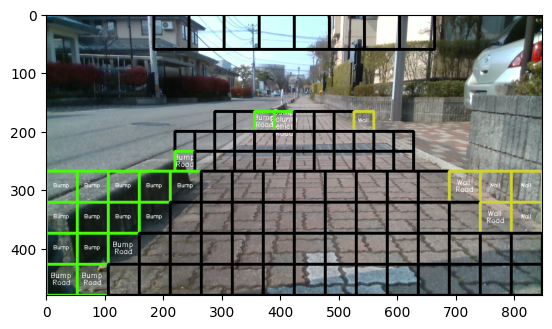

In [35]:
image_num = 350
image_path = Path(GENERATED_IMAGE_DIR / listdir(GENERATED_IMAGE_DIR)[image_num]) 
image = mpimg.imread(image_path)
plt.imshow(image)
plt.show()